Notebook documenting work and analyses for selection of HCR probes to discriminate transcriptomic types within anterior thalamic nuclei.

In [1]:
import anndata as ad
import pandas as pd
import scanpy as sc
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

In [2]:
# Load MERFISH data
merData = ad.read_h5ad("../../data/merfish_609882_AIT17.1_annotated_TH_ZI_only_2023-02-16_00-00-00/atlas_brain_609882_AIT17_1_annotated_TH_ZI_only.h5ad")

# Subset to neuronal
merData = merData[merData.obs["division_id_label"].isin(["3 PAL-sAMY-TH-HY-MB-HB neuronal","2 Subpallium GABAergic","4 CBX-MOB-other neuronal"])]

In [3]:
# Load sequencing data
seqData = ad.read_h5ad("../../data/rnaseq_AIT17.2_2022-12-15_12-00-00/rnaseq/processed.U19_TH-EPI.postQC.h5ad")

## Analysis functions

In [8]:
def countTypes(annData,label):
    # Quick function to check an AnnData object for the number of cells belonging to each of a given label
    countTypes = annData.obs[label].unique()
    countDF = pd.DataFrame([sum(annData.obs[label] == name) for name in countTypes], 
                             columns= ["Count"], index = countTypes)
    countDF = countDF.sort_values(by = "Count", ascending=False)
    return countDF

def plotGenes(genes, section = '1198980080'):
    """ Plot spatial expression of a requested list of genes for a given section of MERFISH data """
    
    # Clean inputs
    if type(genes) != list:
        genes = [genes]
    
    # Functionality to call sections by name or sequentially iterate through them
    uniqueSections = merData.obs["section"].unique()
    if section not in uniqueSections:
        if int(section) < len(uniqueSections):
            section = uniqueSections[int(section)]
        else:
            raise Exception("Unrecognized section number")
    
    # Subset to requested section
    merSection = merData[merData.obs["section"] == section]
    
    # Set up plot parameters
    nGenes = len(genes)
    nCol = int(np.ceil(np.sqrt(nGenes))) #int(np.floor(np.sqrt(nGenes)))
    nRow = nCol #int(np.ceil(nGenes / nCol)) #Keep square to prevent distortion
    
    # Make smaller if requesting lots of plots
    if nGenes <= 4:
        plt.figure(figsize=(nRow*6.4,nCol*4.8))
    else:
        plt.figure(figsize=(nRow*3.2,nCol*2.4))
        
    # Plot expression for each gene
    for count, gene in enumerate(genes):
        
        # Set colormap
        cnorm = merSection[:,gene].X / merSection[:,gene].X.max() # Normalize to maximal gene expression
        color = plt.cm.viridis(cnorm)

        # Plot
        ax = plt.subplot(nRow,nCol,count+1)
        plt.subplots_adjust(wspace=1, hspace=0.1)
        plt.scatter(merSection.obsm["spatial_cirro"][:,0],merSection.obsm["spatial_cirro"][:,1], color = color, s = 15, edgecolors = "black", linewidth = .2)
        # plt.title(gene);

        # Adjust colorbar to show actual expression levels
        cbar = plt.colorbar()
        cbar.ax.set_yticks(np.linspace(0,1,6))
        cbar.ax.set_yticklabels(np.round(np.linspace(0,1,6) * merSection[:,gene].X.max(),1));
        # plt.clim(0,6)

        plt.tight_layout()
        plt.title(gene)
        plt.axis('off')
    
def plotSectionClusters(subclass = "68_CM-IAD-CL-PCN Glut", sections = ['1198980086', '1198980092','1198980095', '1198980098'],palette = "Spectral_r", subset = 0):
    """ Function to plot all clusters from a specific subclass in a given slice, with a chosen color palette."""
    
    # Subset to requested slice
    merSection = merData[merData.obs["section"].isin(sections)]
    
    # Want to create a dictionary of each subclass contained within a given class
    # First create unique tuples with each class and subclass pair
    groupPairs = set(zip(merSection.obs["Level2_id_label"],merSection.obs["cluster_label"]))

    # Then initialize a dictionary where each subclass is a key corresponding to an empty list
    classDict = {pair[0]: [] for pair in groupPairs}

    # Add each cluster to the corresponding class list
    for pair in groupPairs:
        classDict[pair[0]].append(pair[1])

    # Further subset to top N clusters, if requested
    if subset:
        # Subset to only requested subclass
        onlySubclass = merSection[merSection.obs["cluster_label"].isin(classDict[subclass])]
        # Take top N clusters from that subclass
        toColor = list(countTypes(onlySubclass,"cluster_label").head(subset).index)
    else:
        toColor = classDict[subclass]

    # Create a dictionary where each cluster corresponds to a color
    colorDict = {}
    colorCount = 0

    # Create the appropriate colormap by blending the requested palette for the appropriate number of clusters
    colorBlend = sns.color_palette(palette, n_colors=len(toColor))
#     sns.palplot(colorBlend)

    # Populate color dictionary
    for pair in groupPairs:

        # Assign colors to requested subclass, otherwise color black
        if pair[1] in toColor:
            colorDict[pair[1]] = colorBlend[colorCount]
            # print(pair[1]) 
            colorCount += 1
        else:
            colorDict[pair[1]] = 'black'

    # Prepare plotting
    nSections = len(sections)
    nCol = int(np.floor(np.sqrt(nSections)))
    nRow = int(np.ceil(nSections / nCol))
    
    # Make plots smaller if lots of figures
    if nSections <= 4:
        plt.figure(figsize=(nRow*6.4,nCol*4.8))
    else:
        plt.figure(figsize=(nRow*3.2,nCol*2.4))
            
    # Plot each slice successively
    for count, tissue in enumerate(sections):
        
        ax = plt.subplot(nRow,nCol,count+1)
        plt.subplots_adjust(wspace=.1, hspace=.1)
            
        merSection = merData[merData.obs["section"] == tissue]
        for cl in merSection.obs["cluster_label"].unique():
            x = merSection[merSection.obs["cluster_label"] == cl]
            if colorDict[cl] == "black":
                plt.scatter(x.obsm["spatial_cirro"][:,0],x.obsm["spatial_cirro"][:,1],color = colorDict[cl], s = 15, edgecolors = "black", linewidth = .2,zorder = 0)
            else:
                plt.scatter(x.obsm["spatial_cirro"][:,0],x.obsm["spatial_cirro"][:,1],color = colorDict[cl], s = 15, edgecolors = "black", linewidth = .2)
        plt.title("Section#: " + tissue)
        plt.axis('off')
        plt.tight_layout()
        
    return colorDict

def plotSpatial(level = "cluster_label",group = "1180 RE-Xi Nox4 Glut_3", section = False, color = 'cyan'):
    """ Function to plot the spatial layout of a requested group. """
    
    # Check that level and group pairings match, e.g. did not ask for a cluster within subclass .obs
    if group not in merData.obs[level].unique():
        raise Exception("Requested group is not within the specified annData object .obs level.")
    
    # If specific section is requested, use that. Otherwise use section with greatest number of cells from that group.
    if section:
        section = checkSectionNumber(merData,section)
    else:
        section = merData[merData.obs[level] == group].obs["section"].mode()[0]
        
    # Subset to requested section
    sectionData = merData[merData.obs["section"] == section]
    groupData = sectionData[sectionData.obs[level] == group]
    
    # Plot
    plt.figure(dpi=120)
    plt.scatter(sectionData.obsm["spatial_cirro"][:,0],sectionData.obsm["spatial_cirro"][:,1],color = 'gray', s = 15, edgecolors = "black", linewidth = .2,zorder = 0)
    plt.scatter(groupData.obsm["spatial_cirro"][:,0],groupData.obsm["spatial_cirro"][:,1],color = color, s = 15, edgecolors = "black", linewidth = .2)
    
    plt.title(group + ": section " + section)

def plotSpatialGroups(level = "cluster_label",group = "1180 RE-Xi Nox4 Glut_3", section = 3, color = 'cyan'):
    """ Function to plot the spatial layout of several requested groups. """
    
    # If specific section is requested, use that. Otherwise use section with greatest number of cells from that group.
    section = checkSectionNumber(merData,section)
        
    # Subset to requested section
    sectionData = merData[merData.obs["section"] == section]
    
    # Plot
    plt.figure(dpi=120)
    plt.scatter(sectionData.obsm["spatial_cirro"][:,0],sectionData.obsm["spatial_cirro"][:,1],color = 'gray', s = 15, edgecolors = "black", linewidth = .2,zorder = 0)
    
    # Plot group data
    for name in group:
        groupData = sectionData[sectionData.obs[level] == name]
        plt.scatter(groupData.obsm["spatial_cirro"][:,0],groupData.obsm["spatial_cirro"][:,1],color = color[name], s = 15, edgecolors = "black", linewidth = .2)
    
    plt.title("section: " + section)
    
def checkSectionNumber(annData,section):
    """ Function to convert indexed section calls, e.g. section = 1, 2, 3 rather than ID 1198980092 """
    
    uniqueSections = annData.obs["section"].unique()
    # If section call isn't within list of section names, assume it's an index and convert appropriately.
    if section not in uniqueSections:
        if int(section) < len(uniqueSections):
            section = uniqueSections[int(section)]
        else:
            raise Exception("Unrecognized section number")
    return section

def plotROCs(annData, group, geneList = "Prkcd", groupby = "Level2_id_label", density = True, xRange = 8, color = 'tab:blue'):
    # Function to plot gene expression histograms for two clusters, and then display ROC analysis
    # for logistics regression classification accuracy based on those genes.
    from sklearn.metrics import roc_curve, roc_auc_score, auc, RocCurveDisplay
    from sklearn.linear_model import LogisticRegression
    
    if type(geneList) is not list:
        geneList = [geneList]

    # Setup plotting parameters
    plt.figure(figsize=(12.8,2.4*len(geneList)))
    plt.subplot(len(geneList),2,1)
    
    # Subset to requested group
    groupData = annData[annData.obs[groupby] == group]
    nonGroupData = annData[annData.obs[groupby] != group]
    
    # Create plots for each gene
    for count, gene in enumerate(geneList,1):
        plt.subplot(len(geneList),2,(count*2 - 1))

        ### Plot whole population histogram ###
        plt.hist(nonGroupData[:,gene].X.A, bins = np.arange(0,xRange,.1), alpha = .7, color = 'black',
                label = "Rest of Population", density = density)

        # Plot requested subpopulations, from largest to smallest
        plt.hist(groupData[:,gene].X.A,bins = np.arange(0,xRange,.1), edgecolor = 'black', color = color,
                alpha = .7, label = group, density = density)

        if density:
            plt.ylim([0, 1])
        plt.legend()
        plt.xlabel('Log2p Expression')
        plt.ylabel('PDF')
        plt.title(gene)
        plt.tight_layout()
        
        ### Plot ROC analysis ###
        plt.subplot(len(geneList),2,(count*2))
        x = annData[:,gene].X.A
        y = annData.obs[groupby].to_numpy() == group

        # Fit logstic regression model
        clf = LogisticRegression().fit(x, y)
        yPred = clf.decision_function(x)
        fpr, tpr, thresholds = roc_curve(y, yPred)
        roc_auc = auc(fpr, tpr)
    
        # Display ROC curves
        plt.plot(fpr,tpr, color = color, label = "AUC = " + str(np.round(roc_auc,3)))
        plt.legend(loc = "lower right")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title("ROC")
        plt.tight_layout()

## Demonstrate spatial layout

Text(0.5, 1.0, 'Cluster')

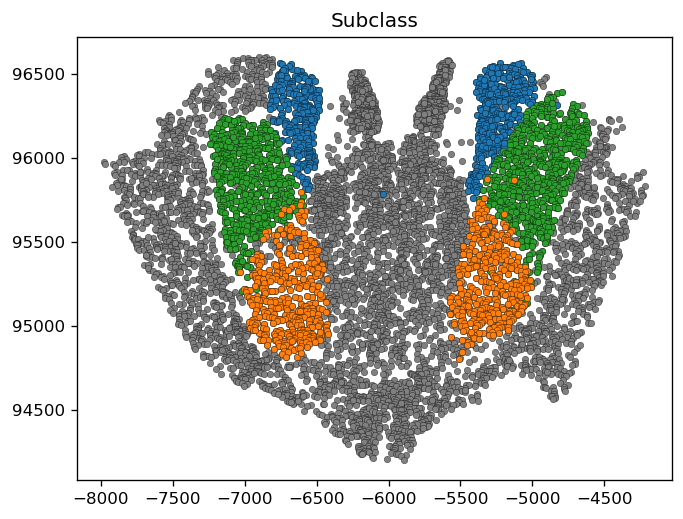

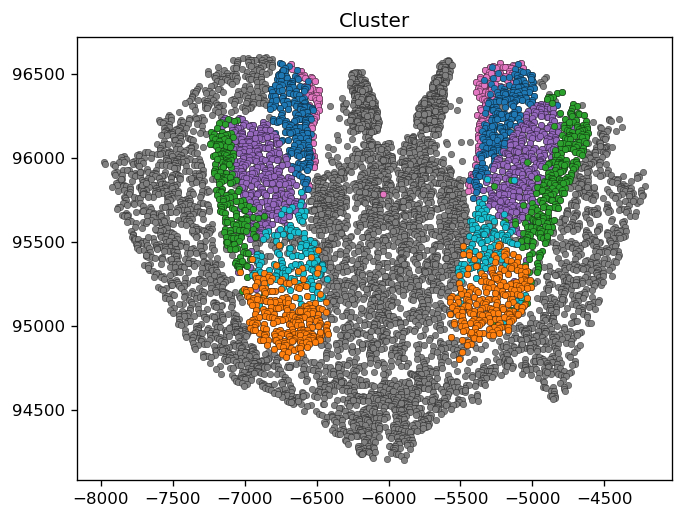

In [5]:
anteriorNuclei = ["1095 AD Serpinb7 Glut", "1096 AD Serpinb7 Glut", # Anterodorsal nucleus
                  "1097 AV Col27a1 Glut","1098 AV Col27a1 Glut", # Anteroventral nucleus
                  "1169 TH Prkcd Grin2c Glut_9", "1171 TH Prkcd Grin2c Glut_9", # Anteromedial nucleus
                 ]

# Plot each nucleus
colorDict = {"1095 AD Serpinb7 Glut":"tab:blue",
             "1096 AD Serpinb7 Glut":"tab:blue",
             "1097 AV Col27a1 Glut":"tab:green",
             "1098 AV Col27a1 Glut":"tab:green",
             "1169 TH Prkcd Grin2c Glut_9":"tab:orange",
             "1171 TH Prkcd Grin2c Glut_9":"tab:orange"}
plotSpatialGroups(level = "cluster_label",group = anteriorNuclei, color = colorDict)
plt.title("Subclass")

# Plot each transcriptomic type
colorDict = {"1095 AD Serpinb7 Glut":"tab:pink",
             "1096 AD Serpinb7 Glut":"tab:blue",
             "1097 AV Col27a1 Glut":"tab:purple",
             "1098 AV Col27a1 Glut":"tab:green",
             "1169 TH Prkcd Grin2c Glut_9":"tab:cyan",
             "1171 TH Prkcd Grin2c Glut_9":"tab:orange"}
plotSpatialGroups(level = "cluster_label",group = anteriorNuclei, color = colorDict)
plt.title("Cluster")

## Look for differentially expressed genes

### Subclass [Level2_id_label] level discrimination

/opt/conda/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


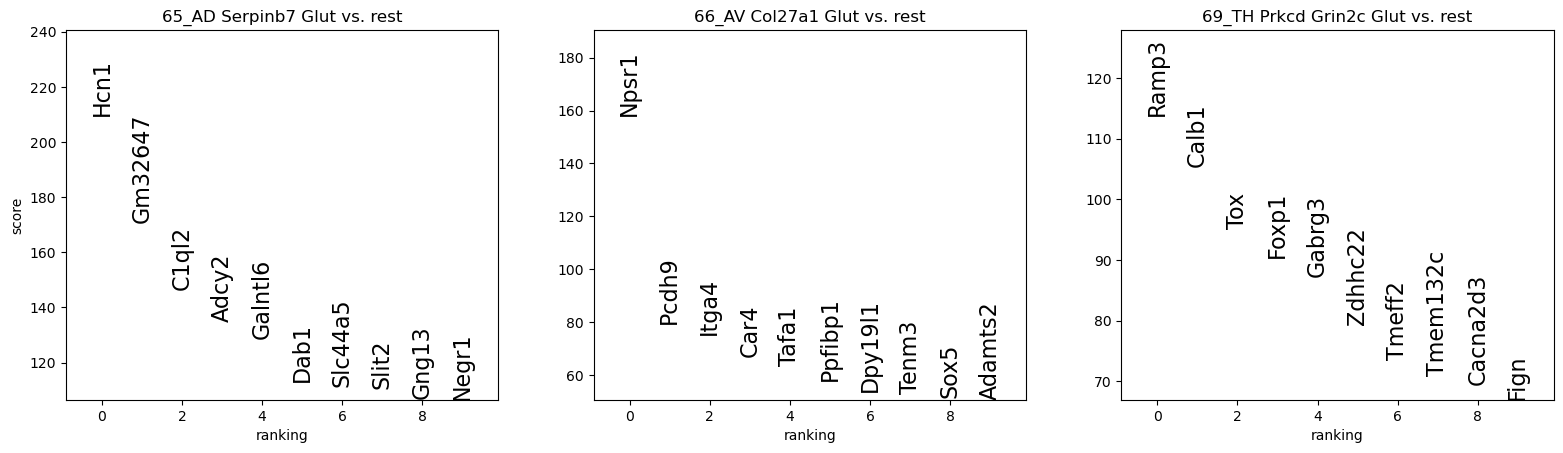

In [10]:
# Grab sequencing data from cells belonging to clusters that map to anterior thalamic nuclei in MERFISH
anteriorNuclei = ["1095 AD Serpinb7 Glut", "1096 AD Serpinb7 Glut", # Anterodorsal nucleus
                  "1097 AV Col27a1 Glut","1098 AV Col27a1 Glut", # Anteroventral nucleus
                  "1169 TH Prkcd Grin2c Glut_9", "1171 TH Prkcd Grin2c Glut_9", # Anteromedial nucleus
                 ]
antSeqData = seqData[seqData.obs["cluster_label"].isin(anteriorNuclei)]

# Compare subclass against all
sc.tl.rank_genes_groups(antSeqData,groupby="Level2_id_label",reference = "rest", pts = True)
sc.pl.rank_genes_groups(antSeqData, n_genes=10, fontsize = 16, sharey=False)

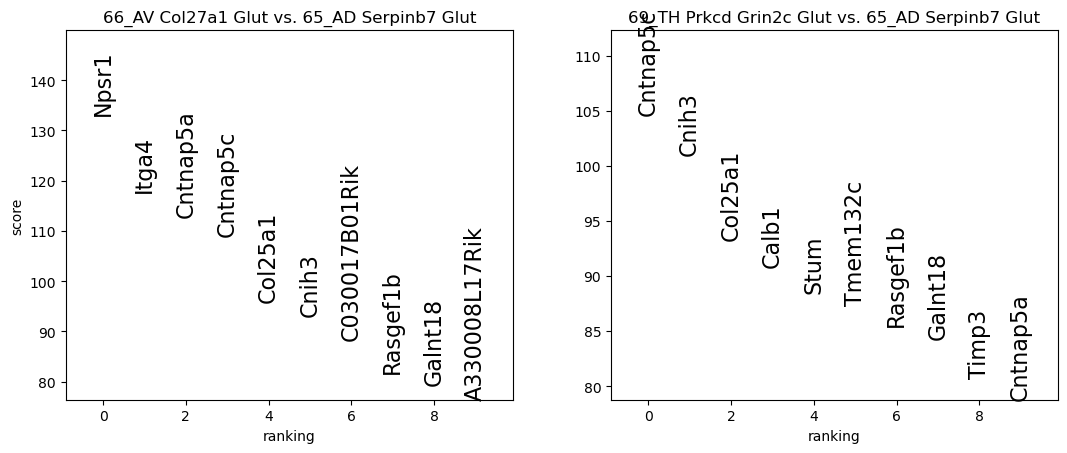

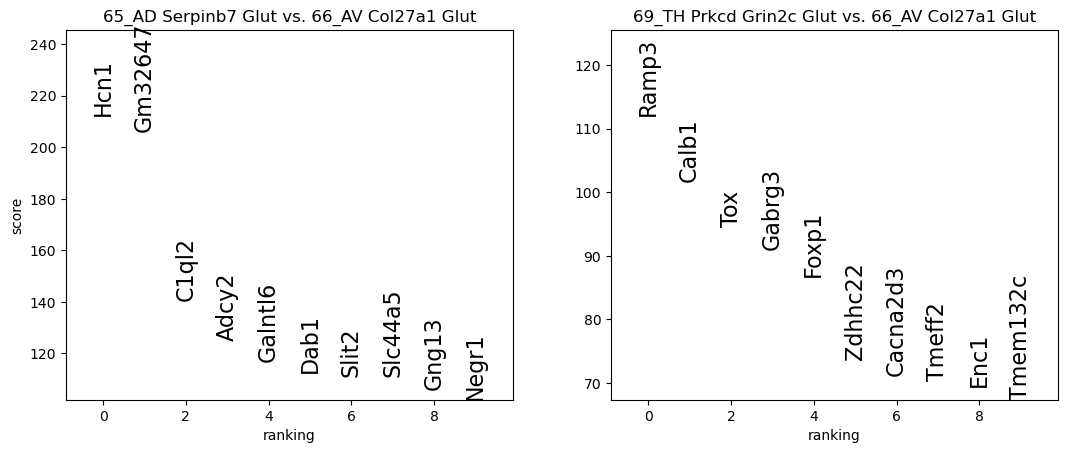

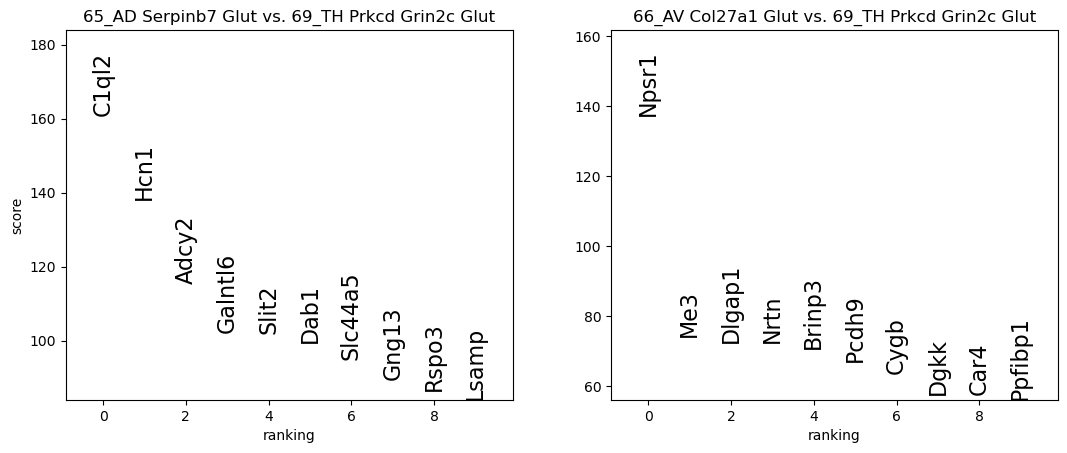

In [11]:
# Compare subclasses pairwise
sc.tl.rank_genes_groups(antSeqData,groupby="Level2_id_label",reference = "65_AD Serpinb7 Glut", pts = True, key_added = "AD ref")
sc.pl.rank_genes_groups(antSeqData, n_genes=10, fontsize = 16, sharey=False, key = "AD ref")

sc.tl.rank_genes_groups(antSeqData,groupby="Level2_id_label",reference = "66_AV Col27a1 Glut", pts = True, key_added = "AV ref")
sc.pl.rank_genes_groups(antSeqData, n_genes=10, fontsize = 16, sharey=False, key = "AV ref")

sc.tl.rank_genes_groups(antSeqData,groupby="Level2_id_label",reference = "69_TH Prkcd Grin2c Glut", pts = True, key_added = "AM ref")
sc.pl.rank_genes_groups(antSeqData, n_genes=10, fontsize = 16, sharey=False, key = "AM ref")

Anterior dorsal nucleus is relatively easy to discriminate, however anteroventral and anteromedial nucleus are more difficult. Some genes which putatively separate the two subclasses appear to have failed within the MERFISH panel (e.g. Npsr1, Me3). Genes that distinguish anteromedial from anteroventral tend to be even more highly expressed in other parts of the thalamus (e.g. Ramp3, Zcchc12). Several genes that are not present within the MERFISH dataset can be crossreferenced with Allen ISH databases, e.g. anteroventral targeting Itga4 (
https://mouse.brain-map.org/experiment/show/77924520) and anteromedial targeting Foxp1 (https://mouse.brain-map.org/experiment/show/69288998)

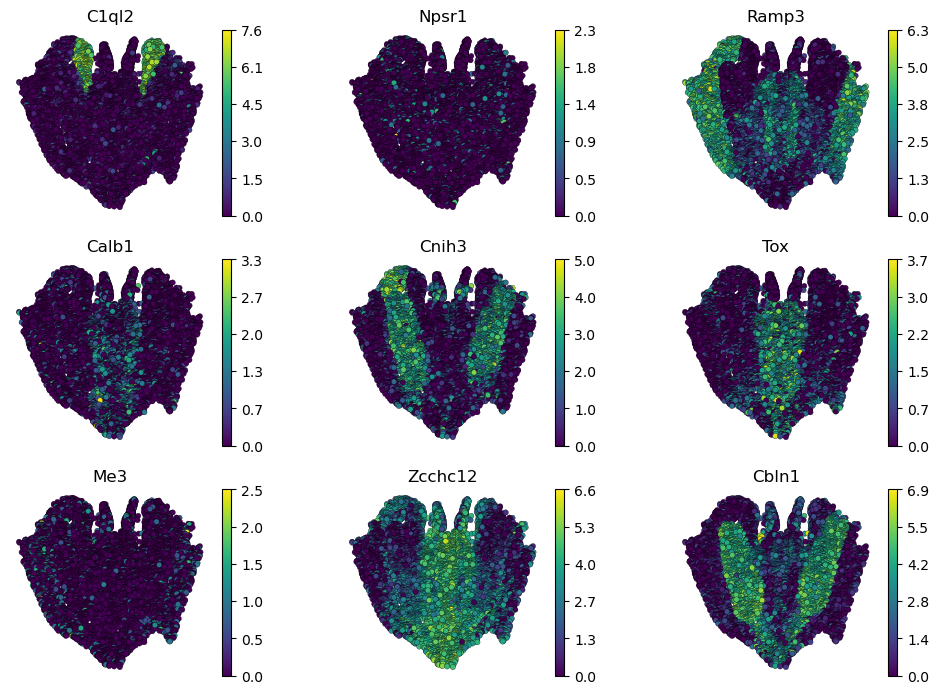

In [19]:
# Several of the top genes
potentialHits = ["C1ql2","Npsr1","Hcn1","Ramp3","Cntnap5c","Calb1","Cnih3","Tox","Me3","Itga4","Zcchc12","Foxp1","Cbln1","Pcdh9"]
inMerfish = []
for gene in potentialHits:
    if gene in merData.var_names:
        inMerfish.append(gene)
    
plotGenes(inMerfish,section = 3)

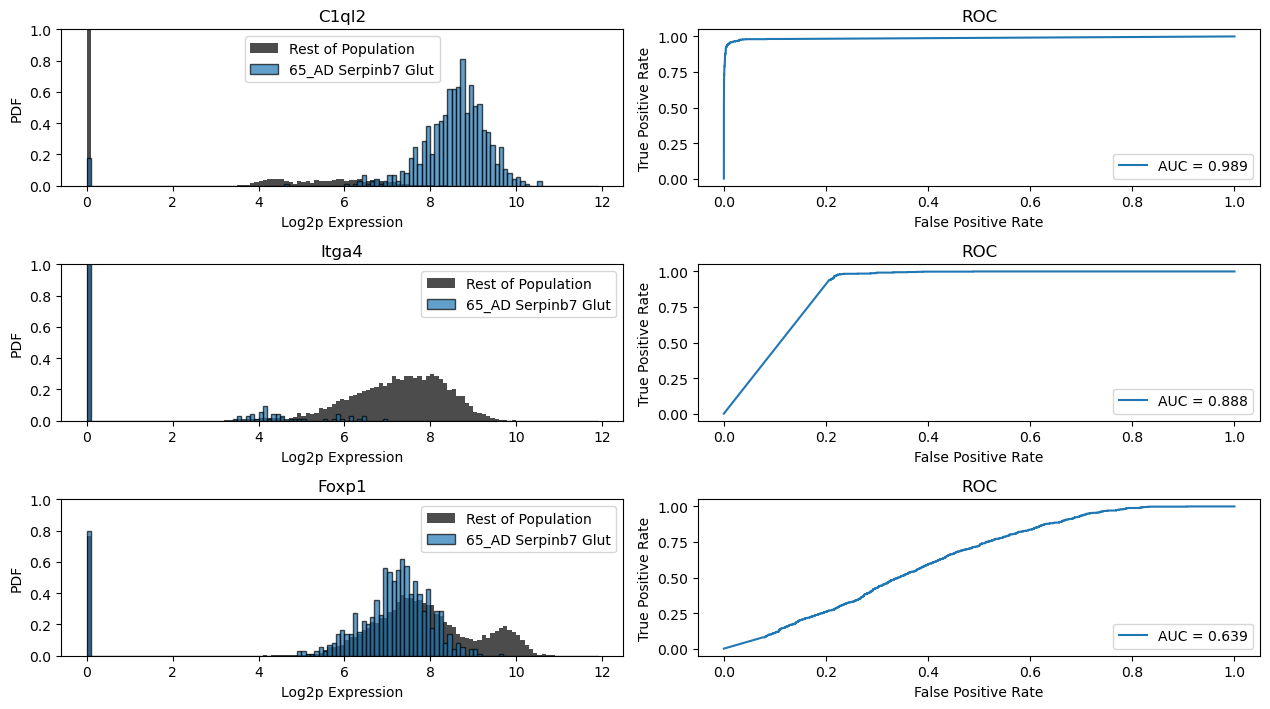

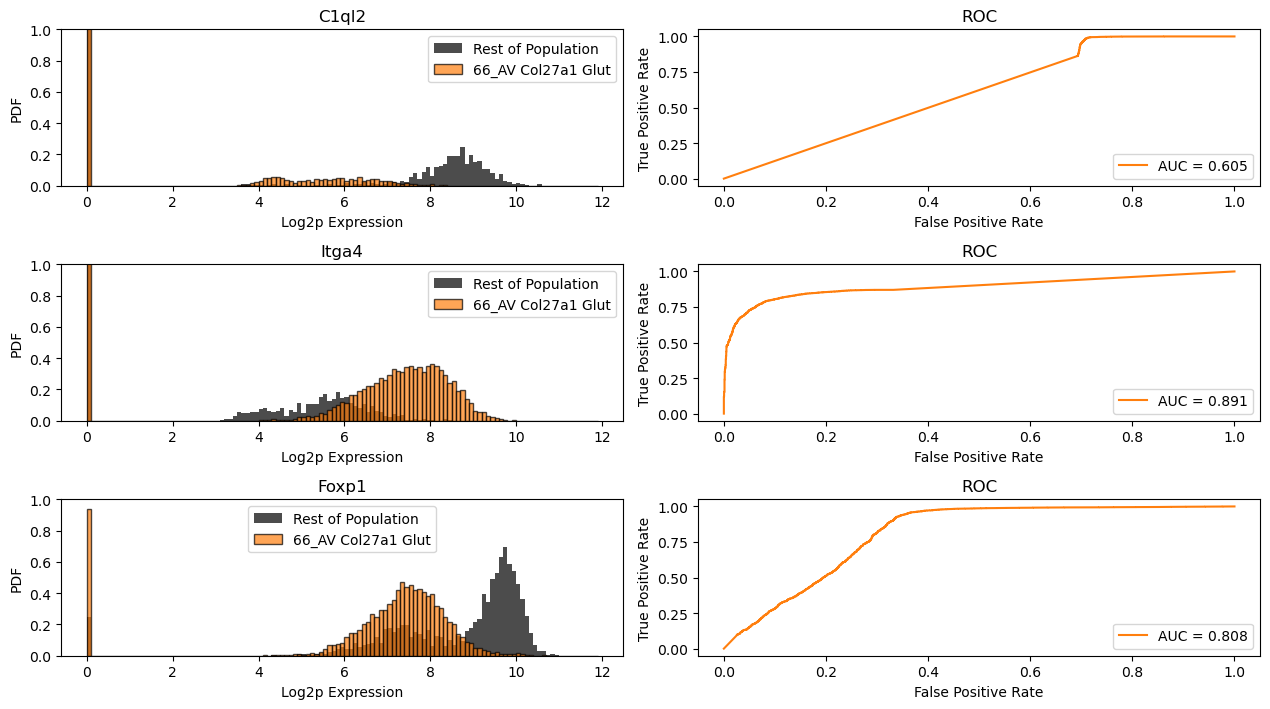

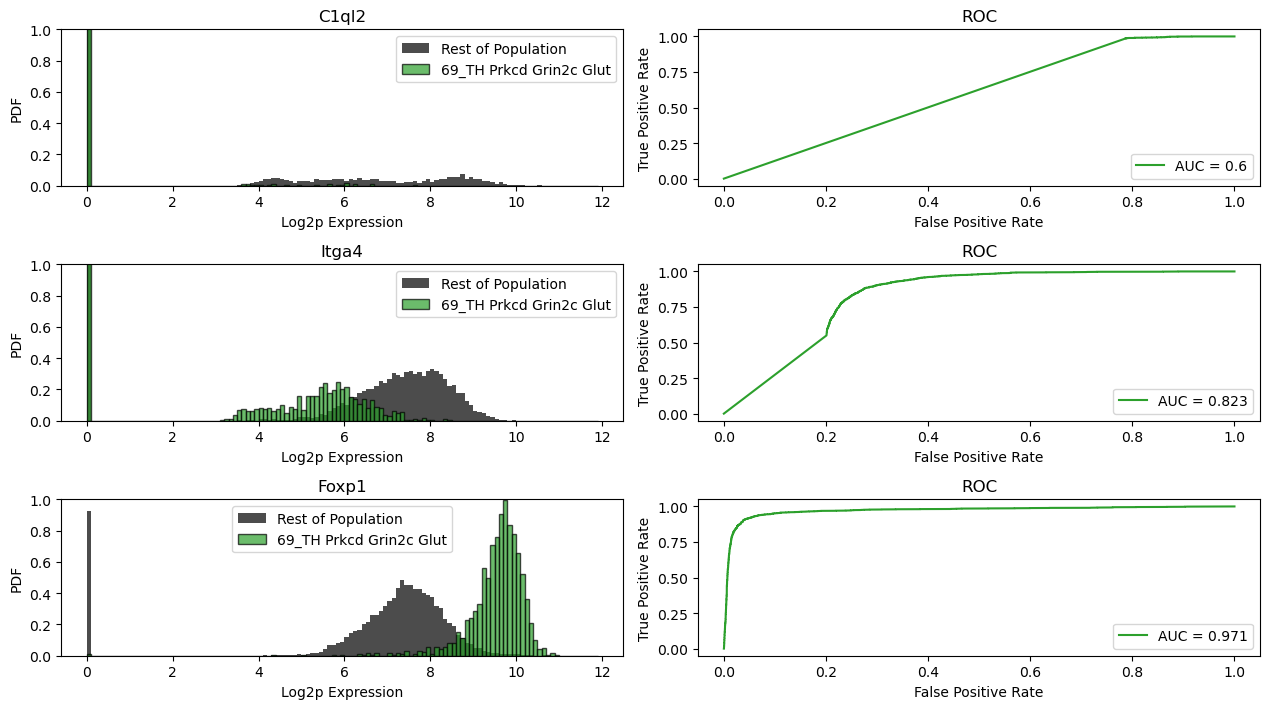

In [12]:
# Look at discriminability of genes within sequencing data
gene = ["C1ql2","Itga4","Foxp1"]
xRange = 12
plotROCs(antSeqData,"65_AD Serpinb7 Glut",gene,xRange = xRange, color = "tab:blue")
plotROCs(antSeqData,"66_AV Col27a1 Glut",gene, xRange = xRange, color = "tab:orange")
plotROCs(antSeqData,"69_TH Prkcd Grin2c Glut",gene, xRange = xRange, color = "tab:green")

### Cluster [cluster_label] level discrimination

/opt/conda/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


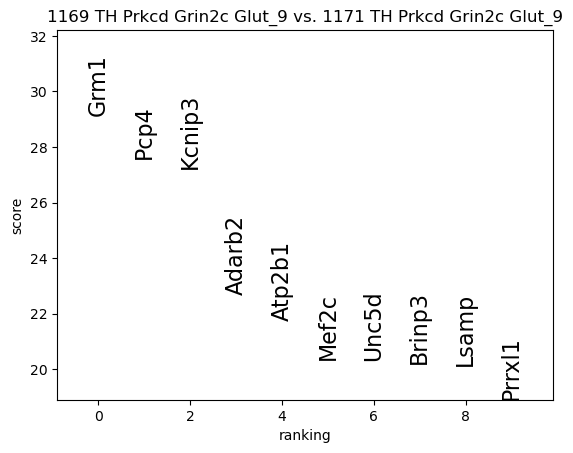

/opt/conda/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


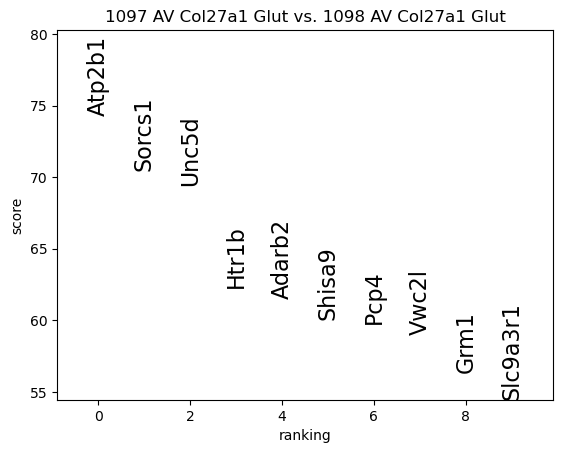

/opt/conda/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


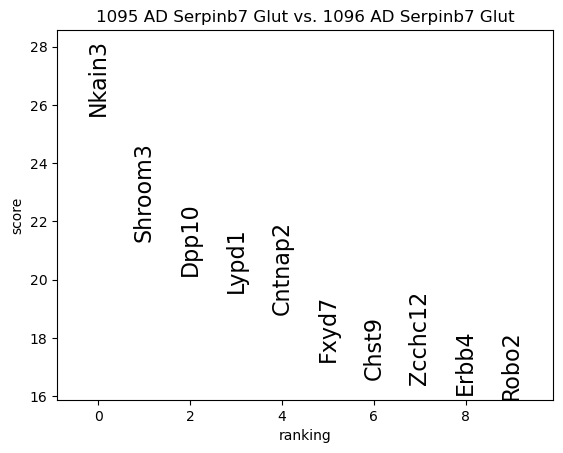

In [7]:
# Look at cluster specific DEGs

## Start with AM
amNuclei = ["1169 TH Prkcd Grin2c Glut_9", "1171 TH Prkcd Grin2c Glut_9"] # Anteromedial nucleus
amSeqData = seqData[seqData.obs["cluster_label"].isin(amNuclei)]

# Compare clusters pairwise
sc.tl.rank_genes_groups(amSeqData,groupby="cluster_label",reference = "1171 TH Prkcd Grin2c Glut_9", pts = True)
sc.pl.rank_genes_groups(amSeqData, n_genes=10, fontsize = 16, sharey=False)

## Next look at AV
avNuclei = ["1097 AV Col27a1 Glut","1098 AV Col27a1 Glut"] # Anteromedial nucleus
avSeqData = seqData[seqData.obs["cluster_label"].isin(avNuclei)]

# Compare clusters pairwise
sc.tl.rank_genes_groups(avSeqData,groupby="cluster_label",reference = "1098 AV Col27a1 Glut", pts = True)
sc.pl.rank_genes_groups(avSeqData, n_genes=10, fontsize = 16, sharey=False)

## Finally look at AD
adNuclei = ["1095 AD Serpinb7 Glut", "1096 AD Serpinb7 Glut"] # Anteromedial nucleus
adSeqData = seqData[seqData.obs["cluster_label"].isin(adNuclei)]

# Compare clusters pairwise
sc.tl.rank_genes_groups(adSeqData,groupby="cluster_label",reference = "1096 AD Serpinb7 Glut", pts = True)
sc.pl.rank_genes_groups(adSeqData, n_genes=10, fontsize = 16, sharey=False)

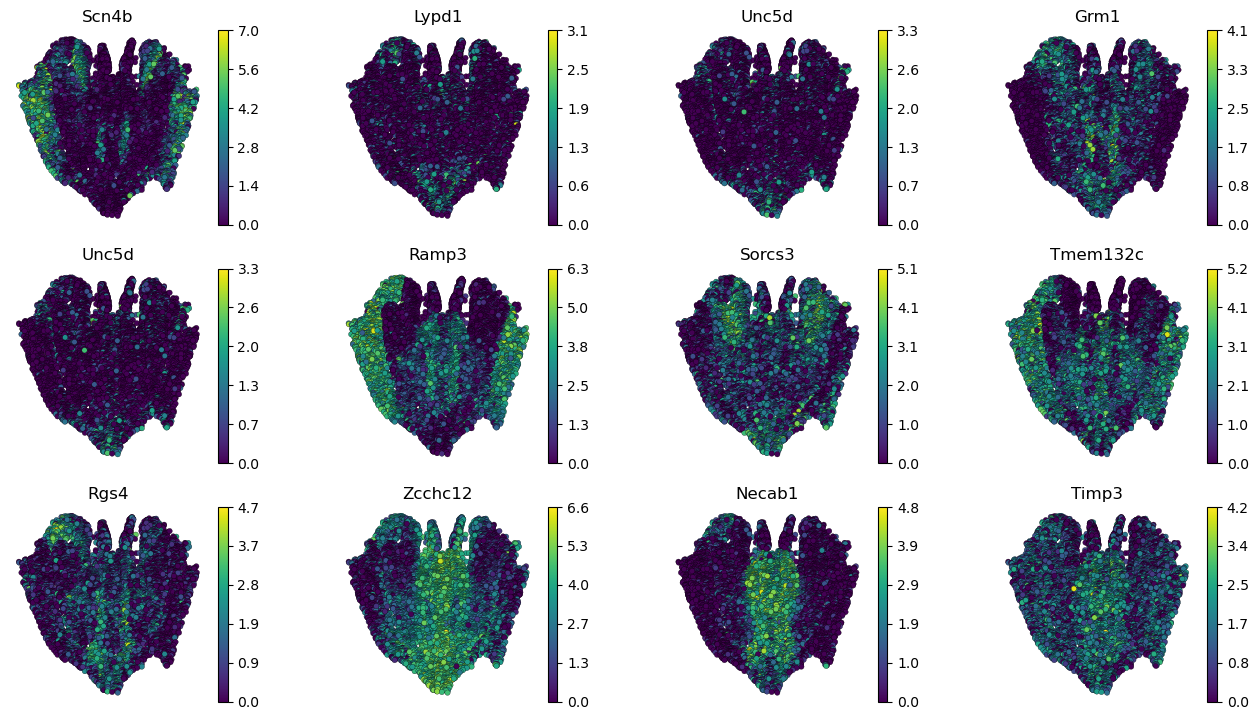

In [14]:
# Many of the top genes lack clear borders defining different clusters within MERFISH data
potentialHits = ["Scn4b","Nkain3","Shroom3","Dpp10","Lypd1","Atp2b1","Sorcs1","Unc5d","Grm1","Unc5d","Kcnip3","Pcp4",
                 "Htr1b","Adarb2","Cntnap2","Ramp3","Sorcs3","Tmem132c","Rgs4","Zcchc12","Necab1","Timp3"]
inMerfish = []
for gene in potentialHits:
    if gene in merData.var_names:
        inMerfish.append(gene)
    
plotGenes(inMerfish,section = 3)

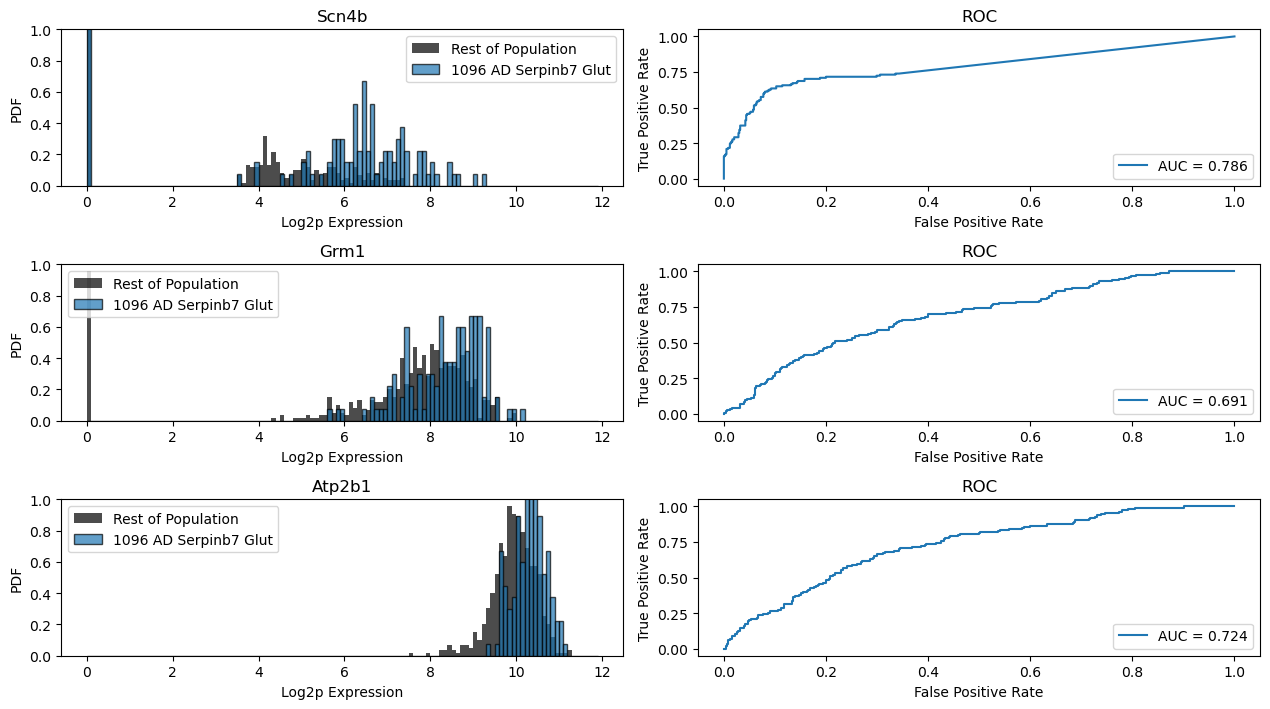

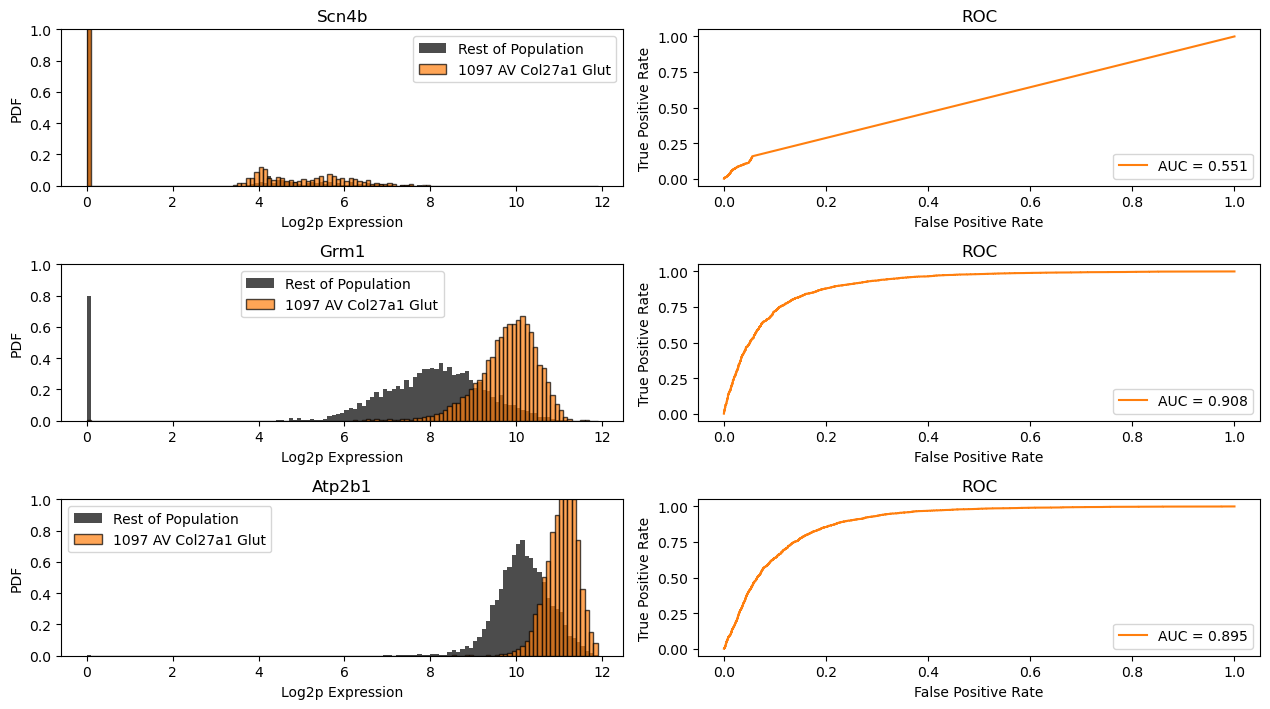

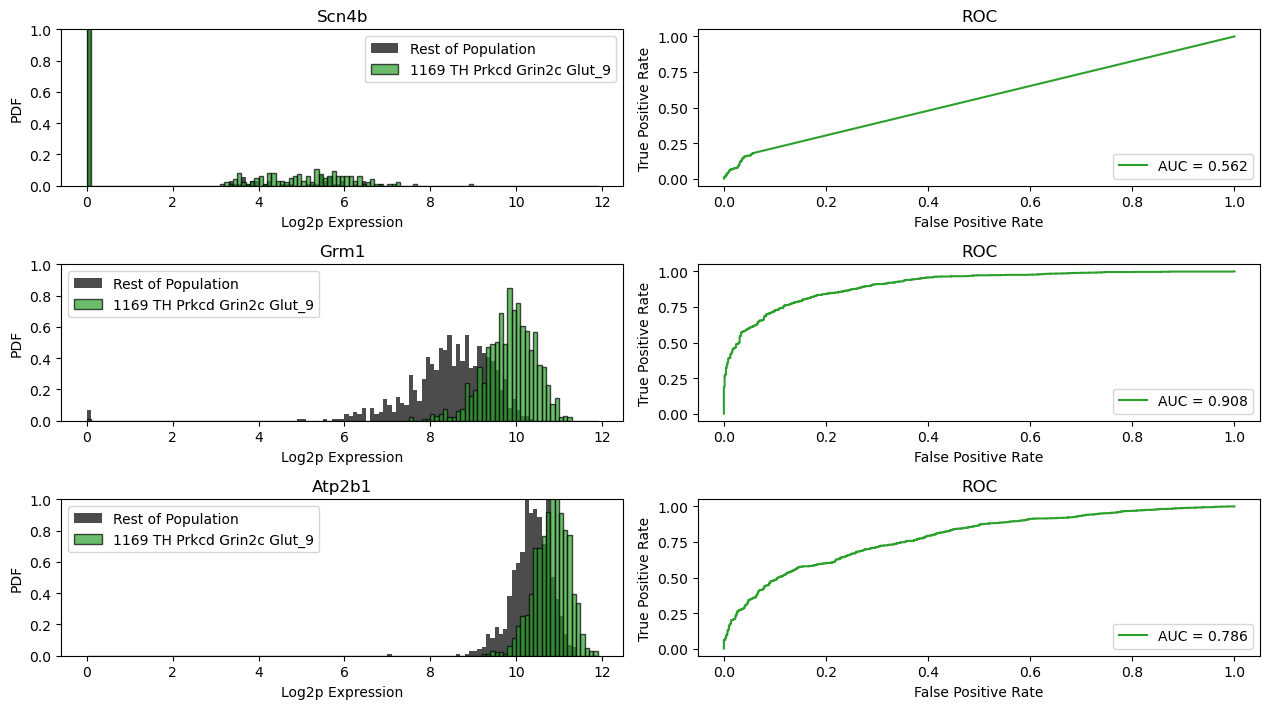

In [21]:
# Look at discriminability of genes within sequencing data
gene = ["Scn4b","Grm1","Atp2b1"]
xRange = 12
plotROCs(adSeqData,"1096 AD Serpinb7 Glut",gene, groupby = "cluster_label", xRange = xRange, color = "tab:blue")
plotROCs(avSeqData,"1097 AV Col27a1 Glut",gene, groupby = "cluster_label", xRange = xRange, color = "tab:orange")
plotROCs(amSeqData,"1169 TH Prkcd Grin2c Glut_9",gene,groupby = "cluster_label",xRange = xRange, color = "tab:green")

Final List<br><br>
AD: C1ql2,    1096: Scn4b <br>
AV: Itga4,    1097: Grm1, Atp2b1<br>
AM: Foxp1,    1169: Grm1, Atp2b1<br>
Cbln1: AV + AM

## Other interesting expression patterns

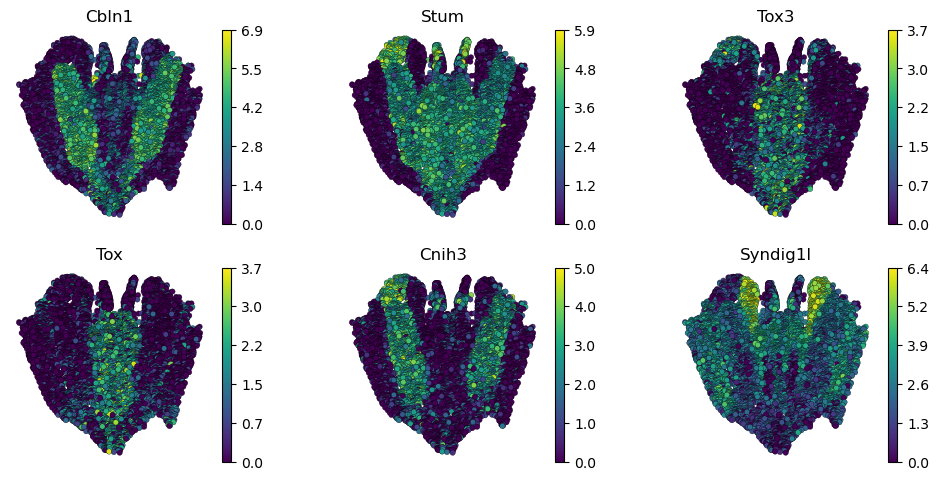

In [6]:
# Other interesting expression patterns
gene = ["Cbln1","Stum","Tox3","Tox","Cnih3","Syndig1l"]
plotGenes(gene)

AM is the only anterior thalamic nucleus that belongs to the Prkcd group rather than its own subclass. Look for DEGs between AM and the rest of Prkcd

<ipython-input-7-29aef77f0fc1>:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  prkcdSeqData.obs["AM"] = pd.Categorical(prkcdSeqData.obs["cluster_label"].isin(amClusters))


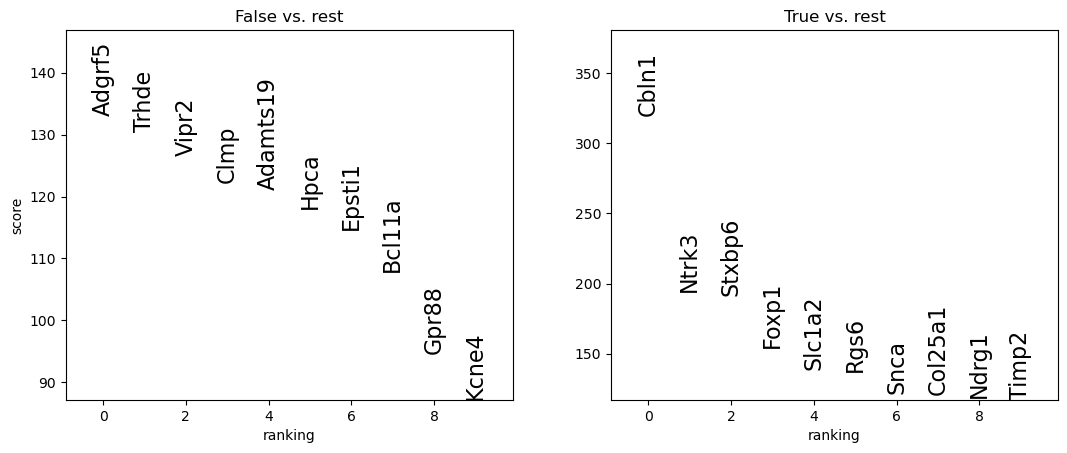

In [7]:
amClusters = ["1169 TH Prkcd Grin2c Glut_9", "1171 TH Prkcd Grin2c Glut_9"]
prkcdSeqData = seqData[seqData.obs["Level2_id_label"] == "69_TH Prkcd Grin2c Glut"]
prkcdSeqData.obs["AM"] = pd.Categorical(prkcdSeqData.obs["cluster_label"].isin(amClusters))

sc.tl.rank_genes_groups(prkcdSeqData,groupby="AM",reference = "rest", pts = True)
sc.pl.rank_genes_groups(prkcdSeqData, n_genes=10, fontsize = 16, sharey=False)

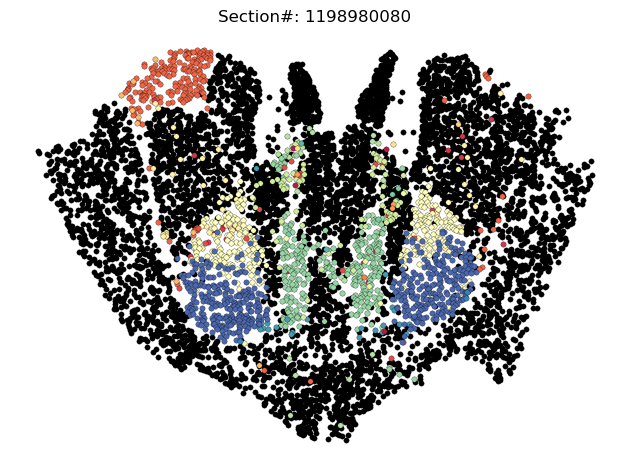

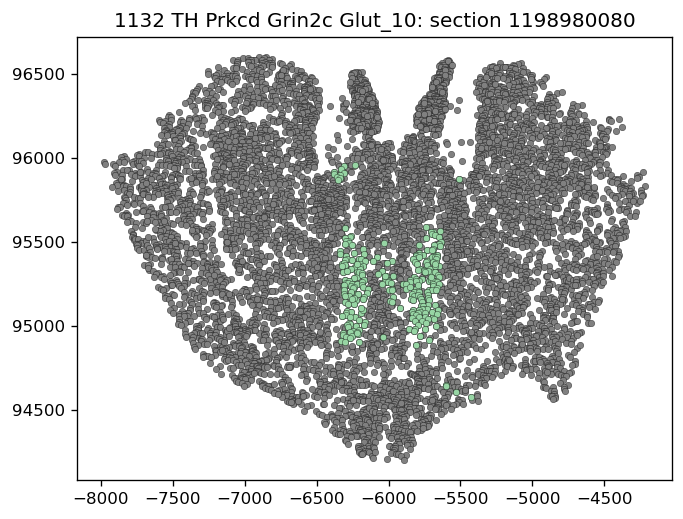

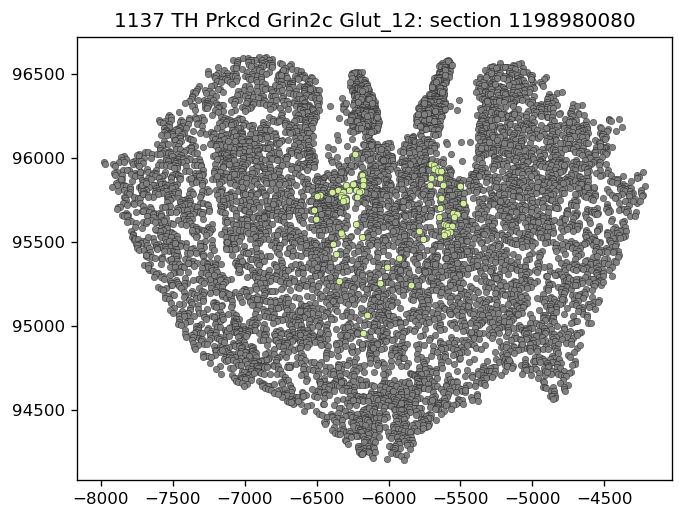

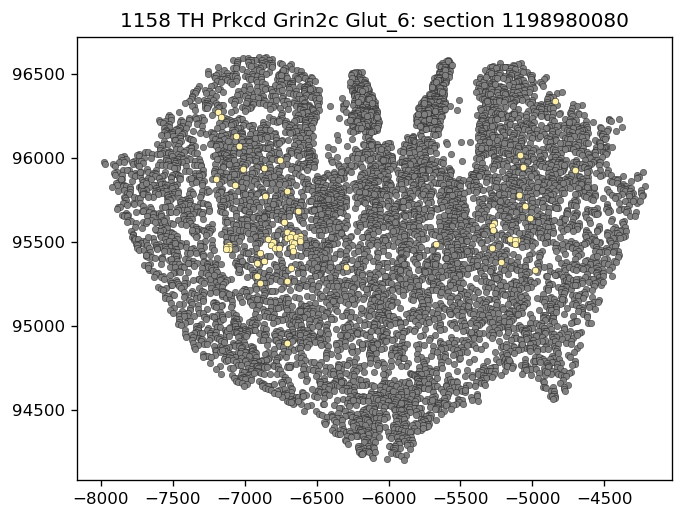

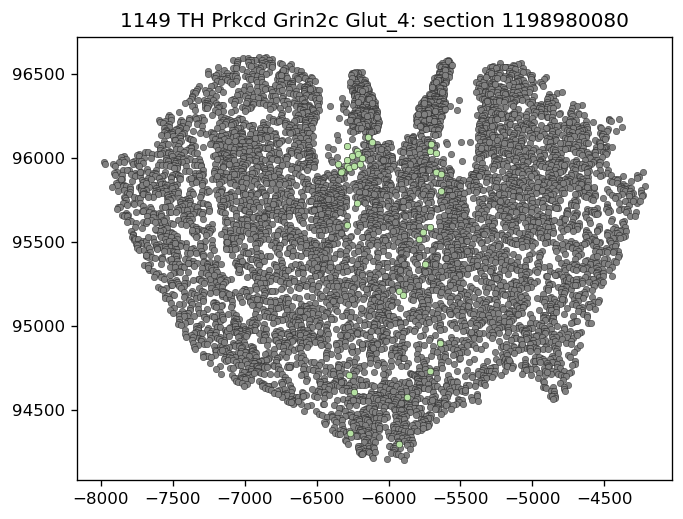

In [11]:
# Plot ATN prkcd groups
section = 3

prkcdColorDict = plotSectionClusters(subclass = "69_TH Prkcd Grin2c Glut",sections = [checkSectionNumber(merData,section)])

prkcdGroups = ["1132 TH Prkcd Grin2c Glut_10", "1137 TH Prkcd Grin2c Glut_12", "1158 TH Prkcd Grin2c Glut_6", "1149 TH Prkcd Grin2c Glut_4"]
for group in prkcdGroups:
    plotSpatial(group = group,section = section, color = prkcdColorDict[group])

In [ ]:
## Code to scrape scanpy rank_gene_groups output for genes present within the MERFISH dataset

# x = []
# for i in range(50):
#     if antSeqData.uns["rank_genes_groups"]["names"]['69_TH Prkcd Grin2c Glut'][i] in merData.var_names:
#         x.append(antSeqData.uns["rank_genes_groups"]["names"]['69_TH Prkcd Grin2c Glut'][i])